In [1]:
import sqlite3
import pandas as pd

In [2]:
con = sqlite3.connect(":memory:")
cur = con.cursor()

https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

In [3]:
link = 'https://raw.githubusercontent.com/eric-bunch/boston_housing/master/boston.csv'

In [71]:
data = pd.read_csv(link)
data.rename(columns = {'MDEV':'MEDV'}, inplace=True)

In [72]:
data.to_sql("boston", con, index=False, if_exists="replace")

506

In [73]:
pd.read_sql(
    """
    SELECT * FROM boston
    limit 5
    """,
    con,
)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [138]:
data.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


1. Выведите количество пустых значений по колонкам CRIM, ZN, INDUS, CHAS, NOX (название колонки, кол-во пустых значений)

In [332]:
#--SELECT count(CRIM), count(ZN), count(INDUS), count(CHAS), count(NOX) FROM boston
#   --where ZN=0 or INDUS=0       NT.count(CRIM) from NT where count(NT.CRIM)=0
pd.read_sql(
    """
    with NT as (
        SELECT CRIM, ZN, INDUS, CHAS, NOX
        FROM boston
        )
    select 'CRIM' as Columns, count(CRIM) as Counts from NT where CRIM=0
    UNION ALL
    select 'ZN', count(ZN) from NT where ZN=0
    UNION ALL
    select 'INDUS', count(INDUS) from NT where INDUS=0
    UNION ALL
    select 'CHAS', count(CHAS) from NT where CHAS=0
    UNION ALL
    select 'NOX', count(NOX) from NT where NOX=0
    """,
    con,
)

,Columns,Counts
0,CRIM,0
1,ZN,372
2,INDUS,0
3,CHAS,471
4,NOX,0


2. Выведите количество уникальных значений по колонокам CRIM, ZN, INDUS, CHAS, NOX (название колонки, кол-во уникальных значений)

In [118]:
pd.read_sql(
    """
    with NT as (
        SELECT CRIM, ZN, INDUS, CHAS, NOX
        FROM boston
        )
    select 'CRIM' as ColName, count(Counts) as Counts from (select count(CRIM) as Counts from NT group by CRIM)
    UNION ALL
    select 'ZN', count(Counts) from (select ZN as Counts from NT group by ZN)
    UNION ALL
    select 'INDUS', count(Counts) from (select INDUS as Counts from NT group by INDUS)
    UNION ALL
    select 'CHAS', count(Counts) from (select CHAS as Counts from NT group by CHAS)
    UNION ALL
    select 'NOX', count(Counts) from (select NOX as Counts from NT group by NOX)
    """,
    con,
)

,ColName,Counts
0,CRIM,504
1,ZN,26
2,INDUS,76
3,CHAS,2
4,NOX,81


3. Выведите колонки, у которых медиана равна минимальному значению (название колонки) выбирая из CRIM, ZN, INDUS, CHAS, NOX.
Напишите какой вывод можно сделать по данным в этих колонках

In [121]:
# Вывод: Медиана равна минимальному значению, если у нас категориальный признак (0,1 / -1/1) со смещением в нижнюю категорию
# как в случае с CHAS, так как больш-во городов не граничат с рекой (0).
# Или если большая часть выборки находится на минимуме как в случае с ZN, так как в больш-ве городов земли уже застроены.
pd.read_sql(
    """
    select ColName from (
    with NT as (
        SELECT CRIM, ZN, INDUS, CHAS, NOX,
        NTILE(2) OVER(ORDER BY CRIM) AS 'NTILE_CRIM',
        NTILE(2) OVER(ORDER BY ZN) AS 'NTILE_ZN',
        NTILE(2) OVER(ORDER BY INDUS) AS 'NTILE_INDUS',
        NTILE(2) OVER(ORDER BY CHAS) AS 'NTILE_CHAS',
        NTILE(2) OVER(ORDER BY NOX) AS 'NTILE_NOX'
        FROM boston
        )
    select 'CRIM' as ColName, max(CRIM)-min(CRIM) as DIF from NT where NTILE_CRIM=1
    UNION ALL
    select 'ZN', max(ZN)-min(ZN) from NT where NTILE_ZN=1
    UNION ALL
    select 'INDUS', max(INDUS)-min(INDUS) from NT where NTILE_INDUS=1
    UNION ALL
    select 'CHAS', max(CHAS)-min(CHAS) from NT where NTILE_CHAS=1
    UNION ALL
    select 'NOX', max(NOX)-min(NOX) from NT where NTILE_NOX=1
    )
    where DIF=0
    
    """,
    con,
)

,ColName
0,ZN
1,CHAS


4. Выведите разницу между среднем количеством комнат(RM) в домах с самой дорогой стоимостью(MEDV) и 25 самыми дешевыми домами. 
Аналогично по 50, 100, 200, 300 самыми дешевыми домами. (кол-во домов(25,50,100,200,300), среднее кол-во комнат в них, среднее кол-во комнат в самых дорогих, разница).
Напишите влияет ли кол-во комнат на стоимость и как сильно.

In [170]:
# Вывод: Разница в комнатах ниже по мере сокращения разницы в стоимости. Влияние ограниченное.
# Исходя из выборки в 500 видим что прирост комнат от 25 дешевых домов к 300 составляет всего 0.25.
# Судя по всему, высока дифференциация по среднему количеству комнат, т.е. комнат резко больше в небольшой части дорогих домов.

# Вопрос: Возможно ли добавить колонку с средним значениям по самым дорогим домам без присваивания ключа
#  и последующего join (также понятно что возможен outer join, но м.б. есть варианты без join)?
pd.read_sql(
    """
    with NT as (
        SELECT RM, MEDV,
        row_number() OVER (ORDER BY MEDV) row_num,
        max(MEDV) over() max_MEDV
        FROM boston
        )
    
    select N_houses, avg_N_cheap, avg_luxury, avg_luxury-avg_N_cheap as DIF from (
        select '1' as id, '25' as N_houses, avg(RM) as avg_N_cheap from NT
        where row_num<=25
        UNION ALL
        select '1', '50', avg(RM) from NT
        where row_num<=50
        UNION ALL
        select '1', '100', avg(RM) from NT
        where row_num<=100
        UNION ALL
        select '1', '200', avg(RM) from NT
        where row_num<=200
        UNION ALL
        select '1', '300', avg(RM) from NT
        where row_num<=300
        ) a
    join (select '1' as id, avg(RM) as avg_luxury from NT where MEDV=max_MEDV) b
    on a.id=b.id
    """,
    con,
)

,N_houses,avg_N_cheap,avg_luxury,DIF
0,25,5.747840,7.484,1.736160
1,50,5.753240,7.484,1.730760
2,100,5.887120,7.484,1.596880
3,200,5.911705,7.484,1.572295
4,300,5.972227,7.484,1.511773


5. Выведите ранги значений колонки LSTAT(процент населения с более низким статусом) в домах с самой дорогой стоимостью (значение LSTAT, стоимость, ранг). Напишите какой вывод можно сделать по этим данным.

In [331]:
# Ранги сконцентрированы в первой 30-ке (низкий процент населеения с низким статсусом). Высокая средняя стоимость
# домов выступает одним из индикаторов высокого уровня благосостояния, что объясняет более низкий процент бедности.

pd.read_sql(
    """
   
    
select rank_num from (
SELECT MEDV, LSTAT, max(MEDV) over() as max_MEDV,
rank() OVER (ORDER BY LSTAT) rank_num
FROM boston
)
where MEDV=max_MEDV
    """,
    con,
)

,rank_num
0,1
1,2
2,6
3,8
4,9
5,15
6,17
7,18
8,26
9,27


array([[<AxesSubplot:title={'center':'rank_num'}>]], dtype=object)

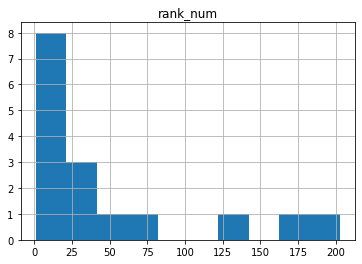

In [186]:
pd.read_sql(
    """
   
    
   select rank_num from (
SELECT MEDV, LSTAT, max(MEDV) over() as max_MEDV,
rank() OVER (ORDER BY LSTAT) rank_num
FROM boston
)
where MEDV=max_MEDV
    """,
    con,
).hist()

6. Выведите среднюю стоимость домов граничащих с рекой(CHAS) и нет (граничит/не граничит, стоимость)

In [219]:
pd.read_sql(
    """
    SELECT CHAS, avg(MEDV) as avg_MEDV FROM boston
    group by CHAS
    """,
    con,  
)

,CHAS,avg_MEDV
0,0.0,22.093843
1,1.0,28.440000


7. Выведите все колонки, у которых среднее значение выше, когда дом граничит с рекой (название колонки) выбирая из CRIM, ZN, INDUS, CHAS, NOX. Напишите какой вывод можно сделать по этим данным.

In [325]:
# Вывод: Граничит с реокй:
# - Доля пром.застройки INDUS выше вероятно из-за слива отходов, традиционной удаленности пром.зон от "города"
# - Концентрация оксидов азота NOX на мой взгляд связана с пром.зонами
# - Количество комнат выше в связи с распорстраненностью частных домов вне "города"
# - Доля чернокожих выше в связи с уровнем жизни вне крупных по населенности городов,
#    занятостью (рабочая сила определенной квалификации) на пром.зонах

# Проблема// сделать запрос лаконичнее
# Нам в любом случае необходимо делать UNION для фильтра по каждой колонке, иначе при фильтрации
#  у нас будут отображаться все колонки в ряд, и тогда любой фильтр будет выводить все колонки,
#  которые потом в любом случае необходимо как-то отсеять. Для такого кода с UNION напрашивается цикл (пытаюсь без него, раз не проходили).
# Пытался применить оконные функции, не нашел применения, тк условия не затрагивают группировку по значениям в колонке..
# Прошу подсказать оптим.решение

pd.read_sql(
    """
    with NT as (
    select CHAS, avg(CRIM) as CRIM,avg(ZN) as ZN,avg(INDUS) as INDUS,avg(NOX) as NOX,avg(RM) as RM,avg(AGE) as AGE,
    avg(DIS) as DIS,avg(RAD) as RAD,avg(TAX) as TAX,avg(PTRATIO) as PTRATIO,avg(B) as B,avg(LSTAT) as LSTAT FROM boston
    group by CHAS
    )
    
    select Columns, Average from (
    select 'CRIM' as Columns, CHAS, max(CRIM) as Average from NT
    UNION ALL
    select 'ZN', CHAS, max(ZN) from NT
    UNION ALL
    select 'INDUS', CHAS, max(INDUS) from NT
    UNION ALL
    select 'NOX', CHAS, max(NOX) from NT
    UNION ALL
    select 'RM', CHAS, max(RM) from NT
    UNION ALL
    select 'DIS', CHAS, max(DIS) from NT
    UNION ALL
    select 'RAD', CHAS, max(RAD) from NT
    UNION ALL
    select 'TAX', CHAS, max(TAX) from NT
    UNION ALL
    select 'PTRATIO', CHAS, max(PTRATIO) from NT
    UNION ALL
    select 'B', CHAS, max(B) from NT
    UNION ALL
    select 'LSTAT', CHAS, max(LSTAT) from NT
    )
    where CHAS=1
            
     
    """,
    con,
)

,Columns,Average
0,INDUS,12.719143
1,NOX,0.593426
2,RM,6.519600
3,B,372.997429


8. Выведите значения долей промышленной застройки(INDUS), концентрации оксидов азота(NOX) и по их перцентилям - 10, 20 ... 100 ( перцетиль(10,20...100),значение INDUS, значение NOX). Напишите прослеживается между ними взаимосвязь

In [333]:
# Вывод: Концентрация оксидов азота существено растет при доле пром.застройки выше 18%

# Дцмаю изначально неверно понял задачу как: вывести перцентили по обоим колонкам (исходя из этой
#  логики решение в следующей ячейке ноутбука). В этом случае не выявить связь между застройкой
#  и концетрацией оксидов азота. Поэтому по азоту NOX просто берем макс по каждой группе INDUS
 
pd.read_sql(
    """
    with NT as (
        SELECT NOX, INDUS,
        ntile(10) over(order by INDUS) as NTILE_INDUS FROM boston
    )
    
        select NTILE_INDUS*10 as Perc, max(INDUS) as max_INDUS, max(NOX) as max_NOX,
        max(NOX)/(avg(max(NOX)) over()) as Div from NT
        group by NTILE_INDUS
    
    """,
    con,
)

,Perc,max_INDUS,max_NOX,Div
0,10,2.89,0.538,0.811585
1,20,4.39,0.647,0.976014
2,30,5.96,0.515,0.776889
3,40,7.38,0.507,0.764821
4,50,9.69,0.585,0.882486
5,60,13.89,0.585,0.882486
6,70,18.10,0.770,1.161563
7,80,18.10,0.740,1.116307
8,90,19.58,0.871,1.313924
9,100,27.74,0.871,1.313924


In [320]:
# Группировка по перцентилям (изначальное решение, по которому не сделать выводов)
pd.read_sql(
    """
    with NT as (
        SELECT NOX, INDUS, ntile(10) over(order by NOX) as NTILE_NOX,
        ntile(10) over(order by INDUS) as NTILE_INDUS FROM boston
    )
    
    select NTILE_NOX*10 as Perc, max_INDUS, max_NOX from (
        select NTILE_NOX, max(NOX) as max_NOX from NT
        group by NTILE_NOX
    ) a

    join (
        select NTILE_INDUS, max(INDUS) as max_INDUS from NT
        group by NTILE_INDUS
    ) b
        on a.NTILE_NOX=b.NTILE_INDUS    
    """,
    con,
)

,Perc,max_INDUS,max_NOX
0,10,2.89,0.426
1,20,4.39,0.442
2,30,5.96,0.472
3,40,7.38,0.507
4,50,9.69,0.538
5,60,13.89,0.580
6,70,18.10,0.609
7,80,18.10,0.671
8,90,19.58,0.713
9,100,27.74,0.871


In [306]:
# Второй вариант решения без group by в нижнеуровневых таблицах,
#  но с partition в них и c group by в таблице над ними
pd.read_sql(
    """
    with NT as (
        SELECT NOX, INDUS, ntile(10) over(order by NOX) as NTILE_NOX,
        ntile(10) over(order by INDUS) as NTILE_INDUS FROM boston
    )
    
    select NTILE_NOX*10 as Perc, max_INDUS, max_NOX from (
        select NTILE_NOX, max(NOX) over (partition by NTILE_NOX) as max_NOX from NT
    ) a

        join (select NTILE_INDUS, max(INDUS) over (partition by NTILE_INDUS) as max_INDUS from NT
    ) b
        on a.NTILE_NOX=b.NTILE_INDUS
        group by Perc  
    
    
    
    """,
    con,
)

,Perc,max_INDUS,max_NOX
0,10,2.89,0.426
1,20,4.39,0.442
2,30,5.96,0.472
3,40,7.38,0.507
4,50,9.69,0.538
5,60,13.89,0.580
6,70,18.10,0.609
7,80,18.10,0.671
8,90,19.58,0.713
9,100,27.74,0.871
